In [17]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models,layers,optimizers
import matplotlib.pyplot as plt

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()





58892288/58889256 [==============================] - 5s 0us/step

In [6]:
original_dataset_dir = '../data/kaggle_original_data'
dir = '../data/cats_and_dogs/'

if not os.path.exists(dir):
    os.mkdir(dir)

base_dir = os.path.join(dir, 'cats_and_dogs_small')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen=ImageDataGenerator(rescale=1./255)
BATCH_SIZE=25

In [7]:
def extract_features(dir,sample_number):
    features=np.zeros(shape=(sample_number,4,4,512))
    labels=np.zeros(shape=(sample_number))
    generator=datagen.flow_from_directory(
        dir,
        target_size=(150,150),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    i=0;

    for inputs_batch, labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=labels_batch
        i+=1
        if i*BATCH_SIZE>=sample_number:
            break
    return features,labels

In [12]:
train_features,train_labels=extract_features(train_dir,2000)
validation_features,validation_labels=extract_features(validation_dir,1000)
test_features,test_labels=extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [15]:
model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
history=model.fit(train_features,train_labels,epochs=30,batch_size=BATCH_SIZE,validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6624 - acc: 0.6075 - val_loss: 0.4774 - val_acc: 0.8360

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  app.launch_new_instance()
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: color is redundan

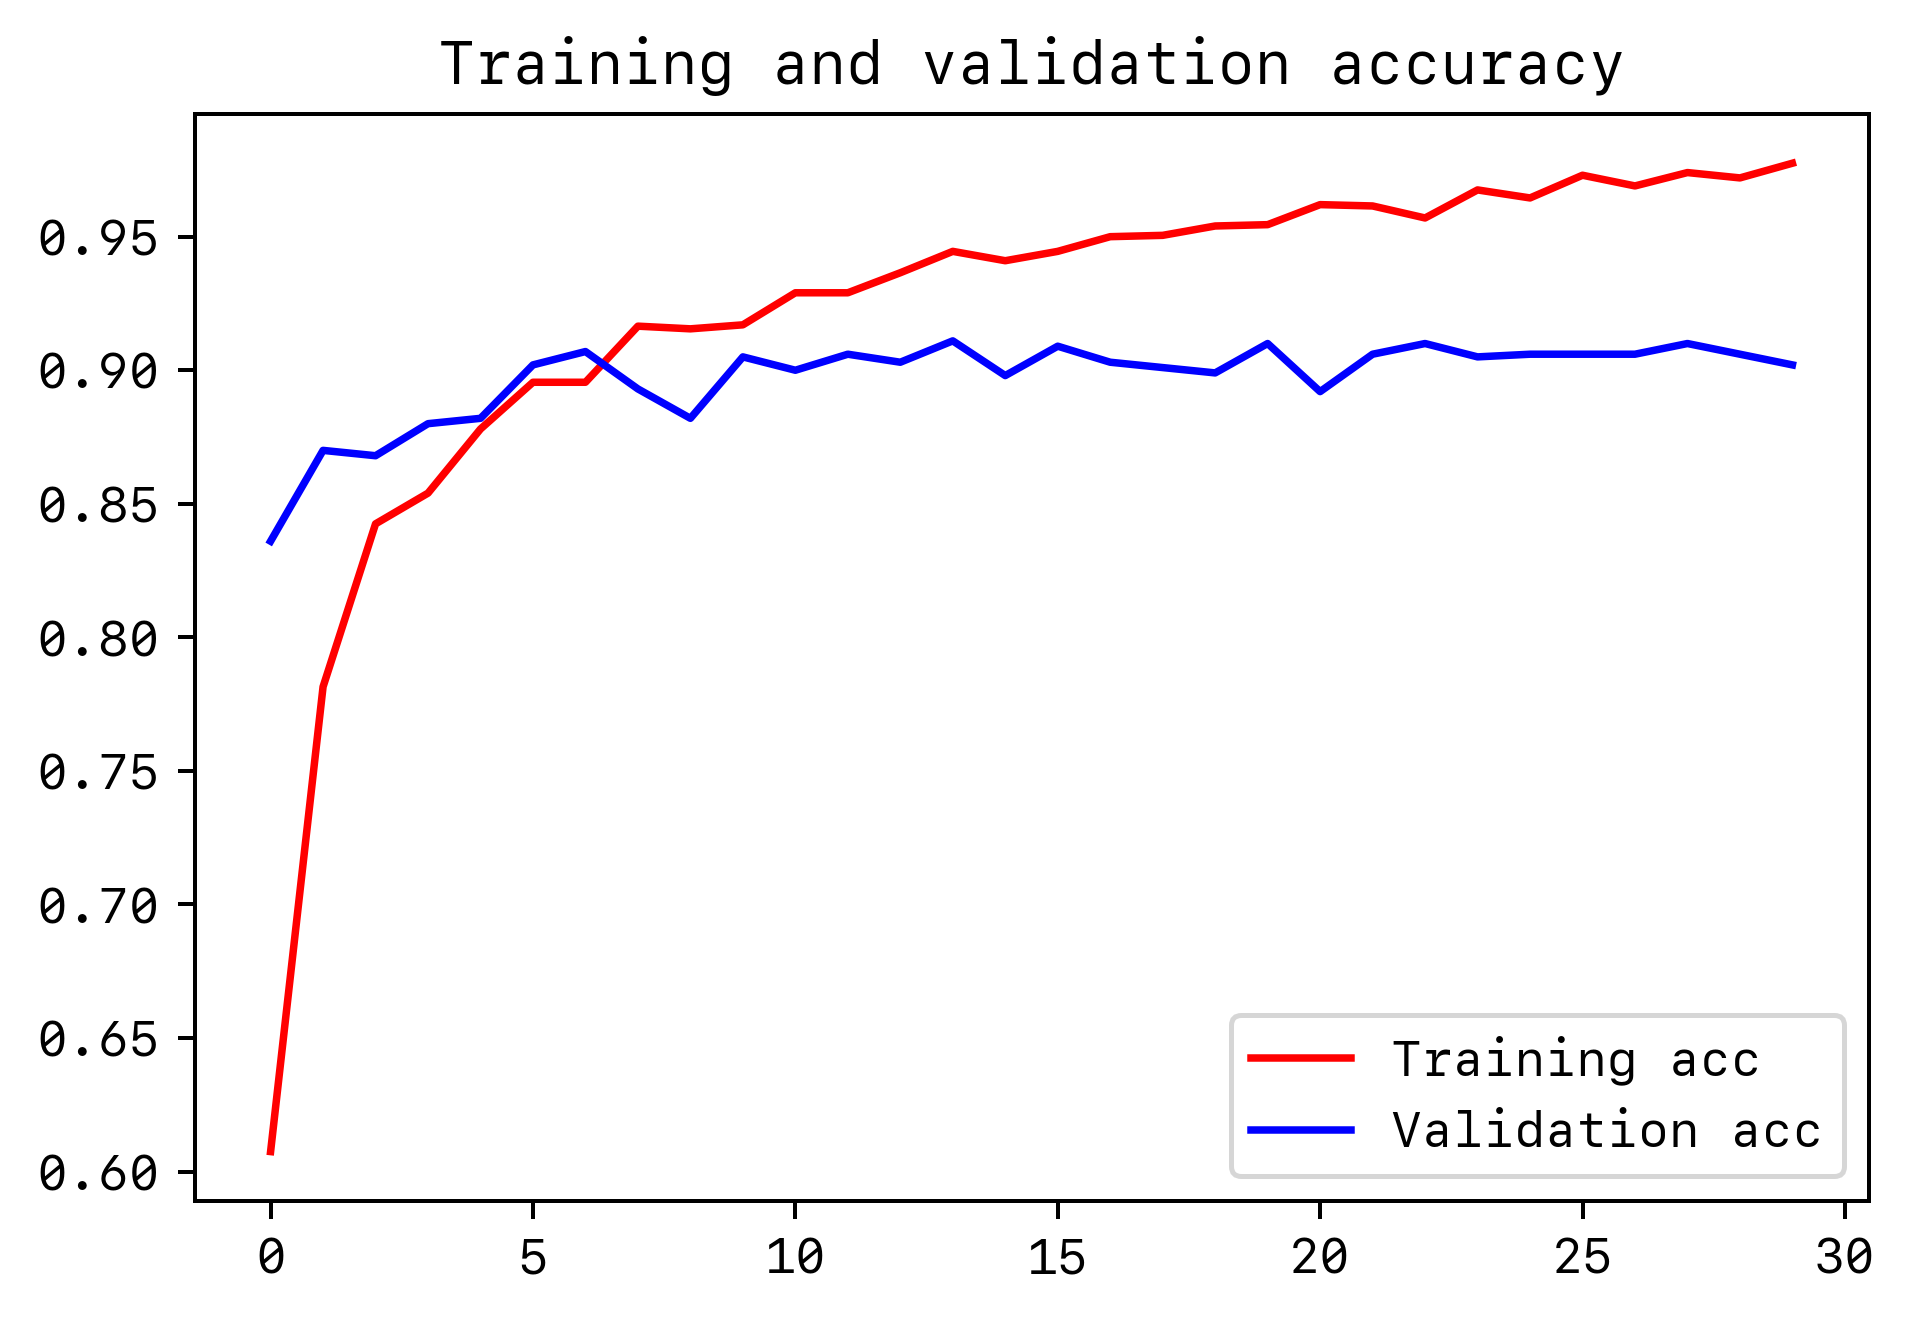

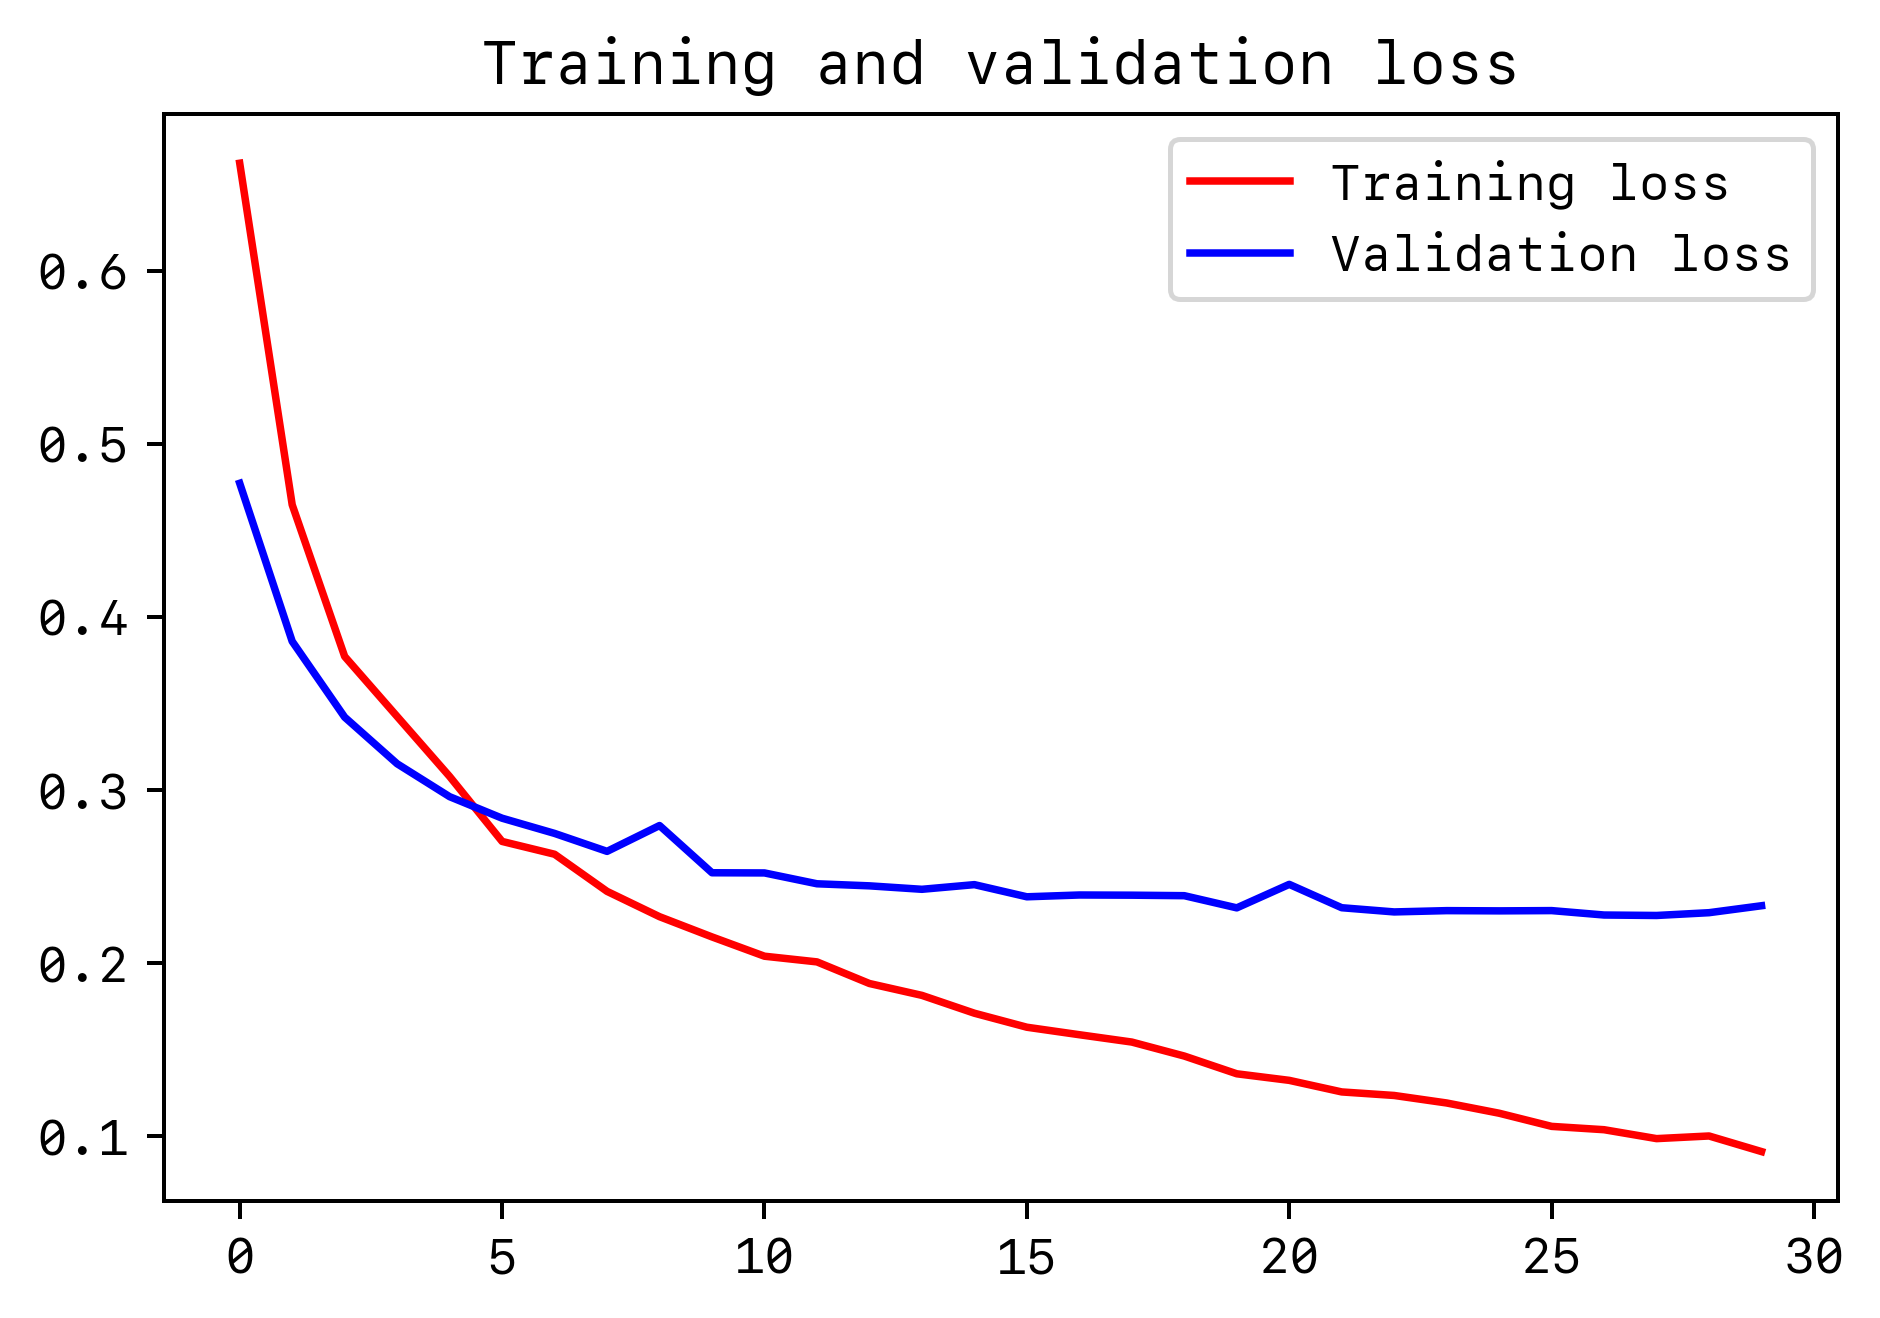

In [19]:
#用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SF Mono']
#用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 360  #图片像素
plt.rcParams['figure.dpi'] = 360  #分辨率

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model_enhanced=models.Sequential()
model_enhanced.add(conv_base)
model_enhanced.add(layers.Flatten())
model_enhanced.add(layers.Dense(256,activation='relu'))
model_enhanced.add(layers.Dense(1,activation='sigmoid'))
model_enhanced.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [23]:
conv_base.trainable=False

model_enhanced.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [24]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
history_enhanced=model_enhanced.fit_generator(
    train_generator,
    steps_per_epoch=80,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

model_enhanced.save('../models/cats_and_dogs/cats_and_dogs_small_vgg16.h5')

Epoch 1/30
80/80 [==============================] - 190s 2s/step - loss: 0.6214 - acc: 0.6505 - val_loss: 0.4948 - val_acc: 0.7824

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  if __name__ == '__main__':


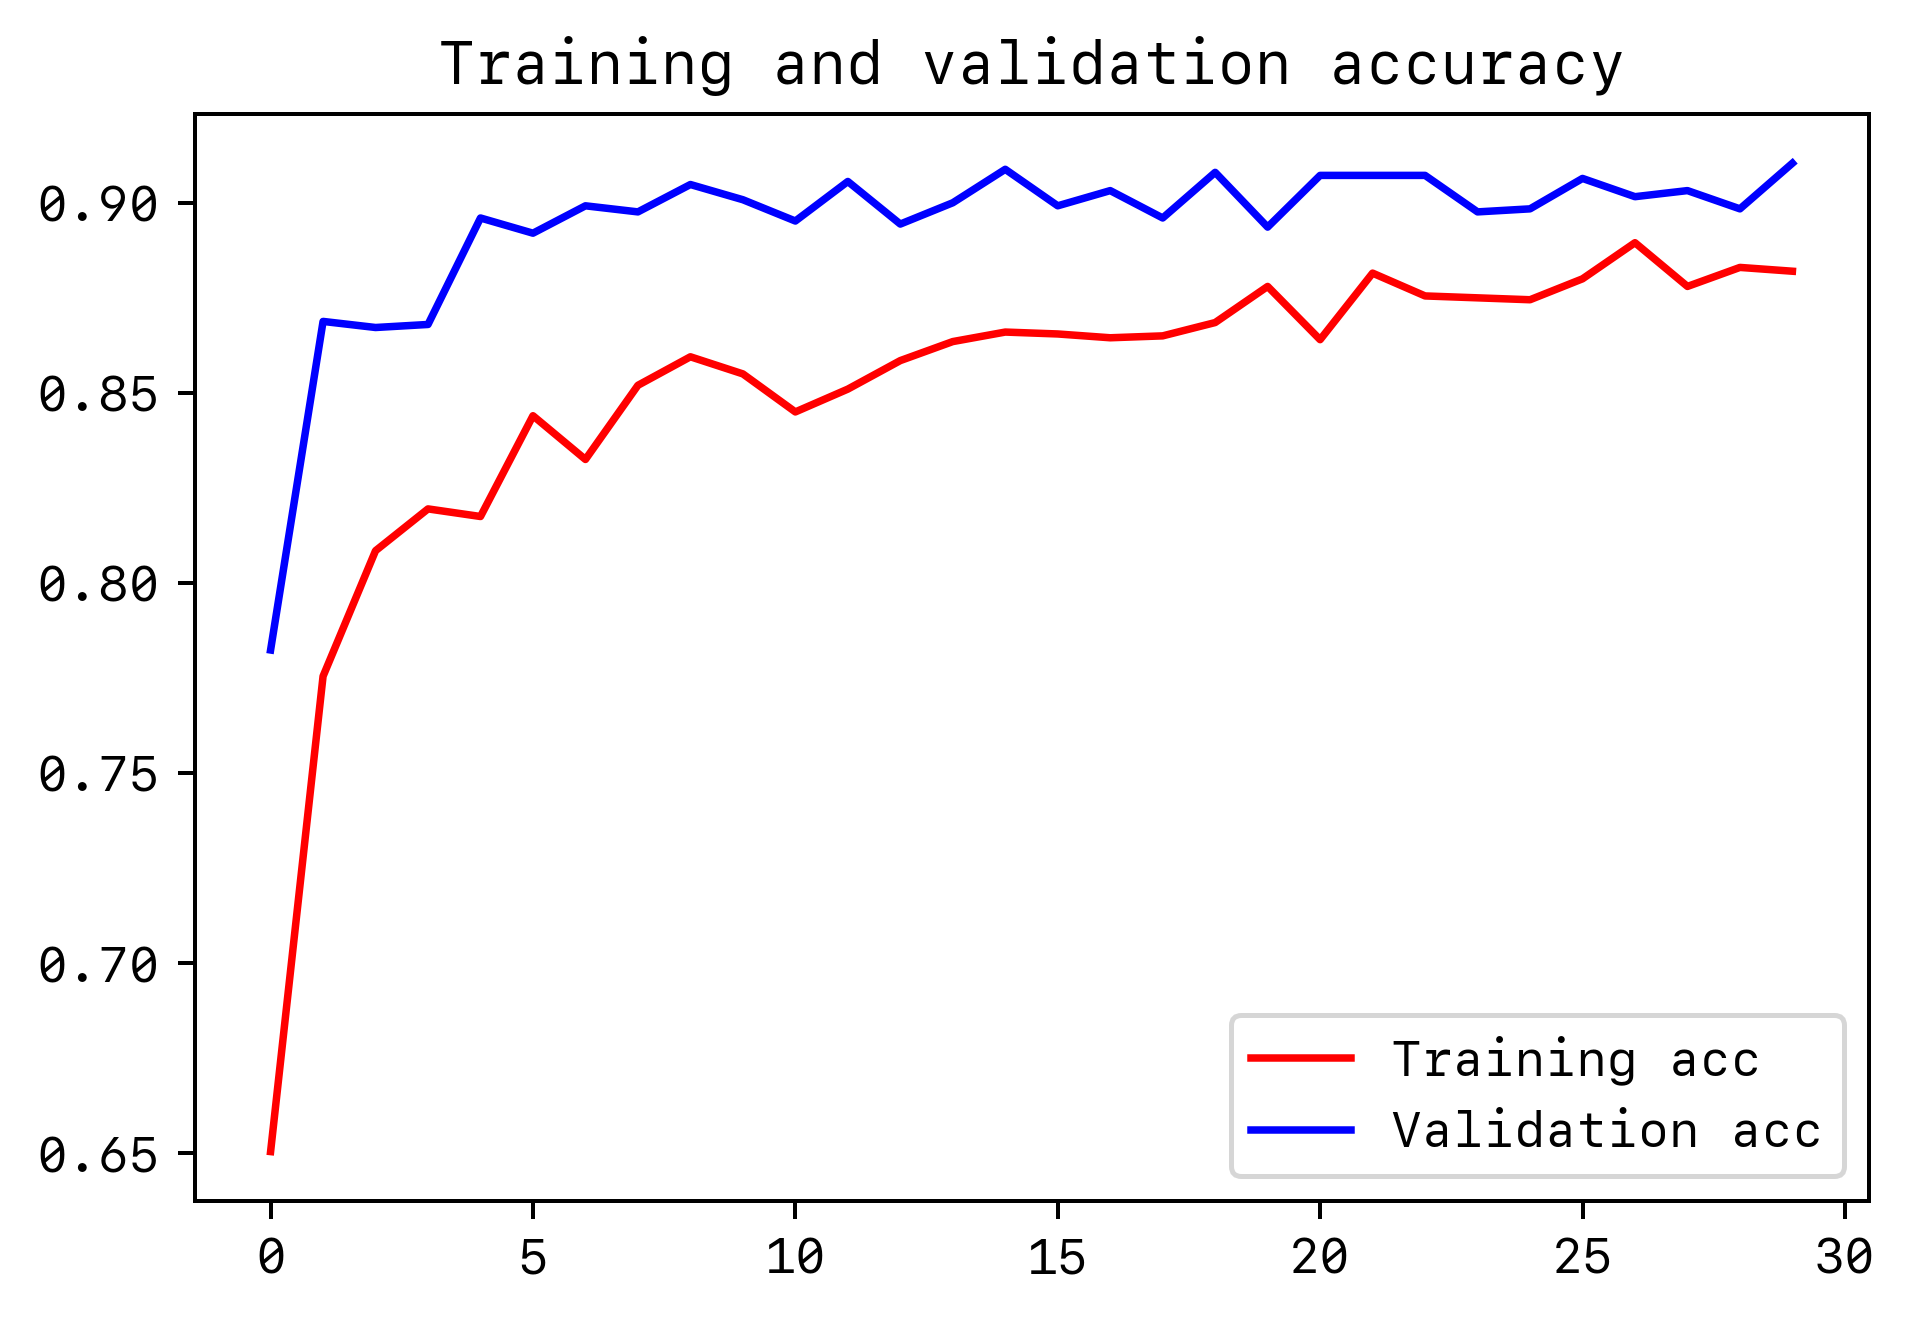

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


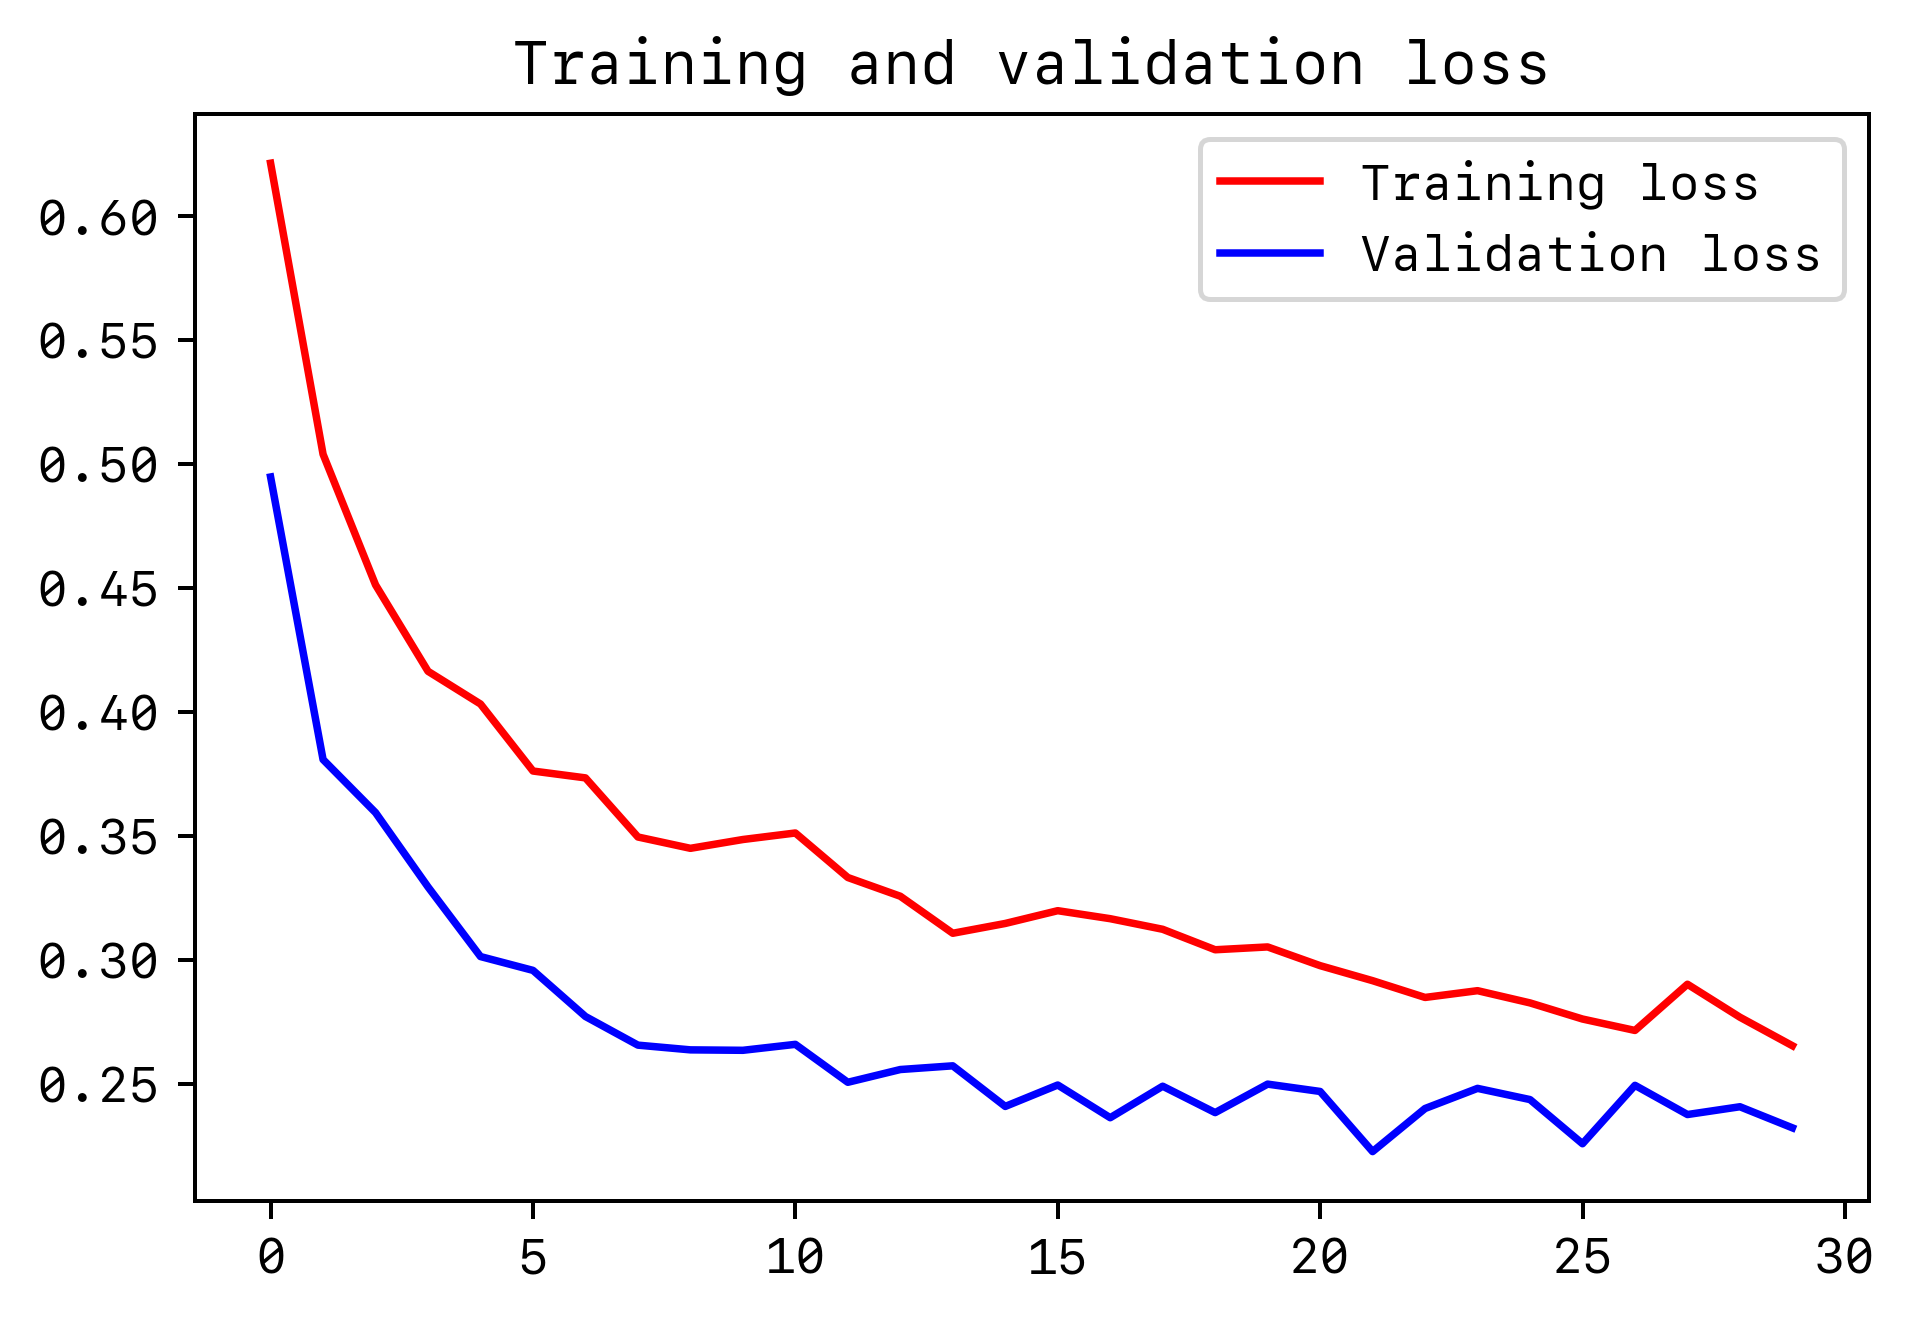

In [29]:
acc = history_enhanced.history['acc']
val_acc = history_enhanced.history['val_acc']
loss = history_enhanced.history['loss']
val_loss = history_enhanced.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
conv_base.trainable=True
set_trainable=False

for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
model_enhanced.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

history_enhanced=model_enhanced.fit_generator(
    train_generator,
    steps_per_epoch=80,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

model_enhanced.save('../models/cats_and_dogs/cats_and_dogs_small_vgg16_tuned.h5')


Epoch 1/100
80/80 [==============================] - 203s 3s/step - loss: 0.2840 - acc: 0.8815 - val_loss: 0.2266 - val_acc: 0.9096

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


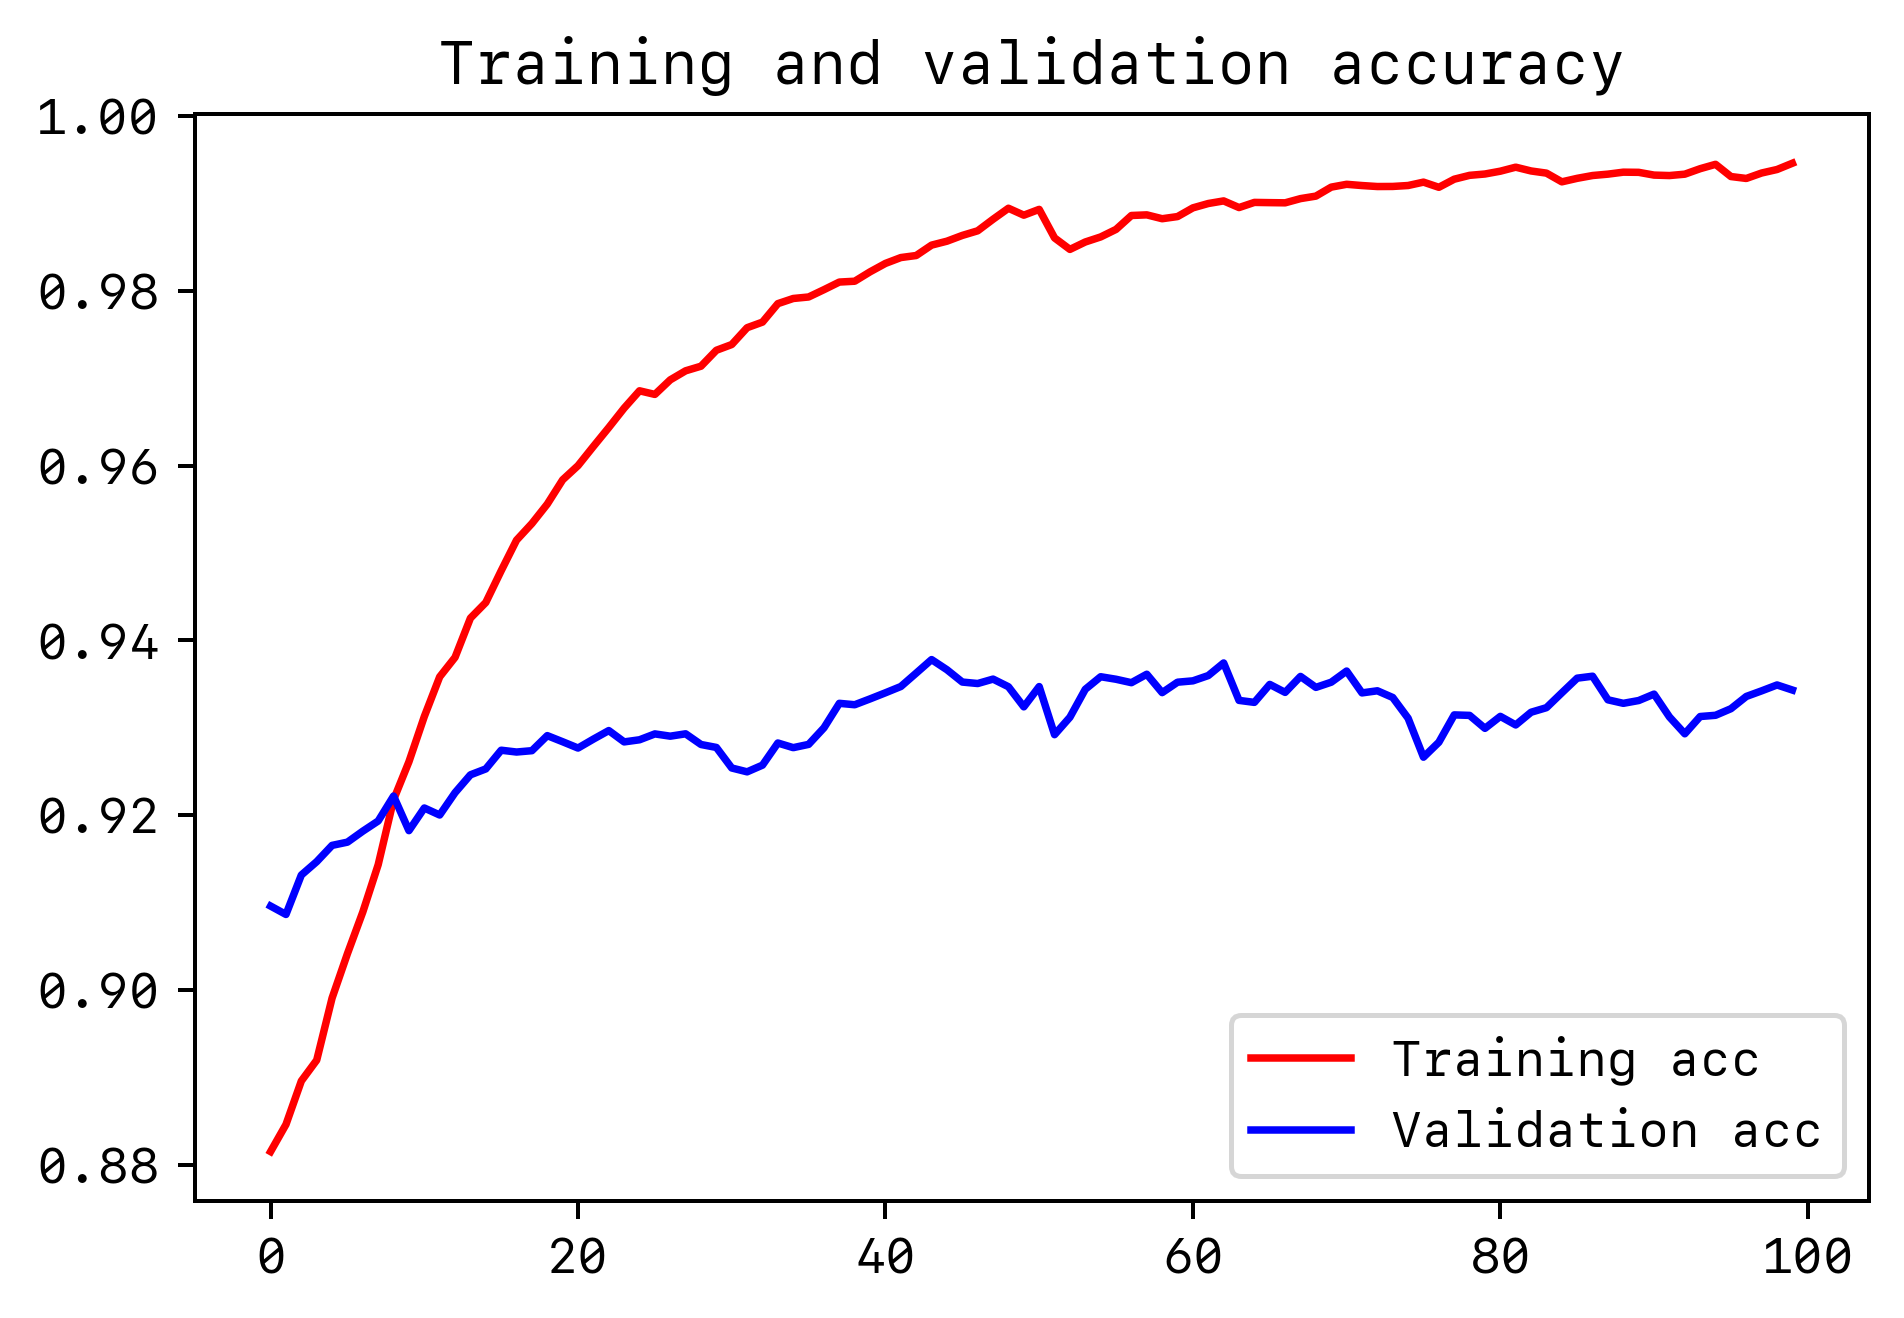

/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


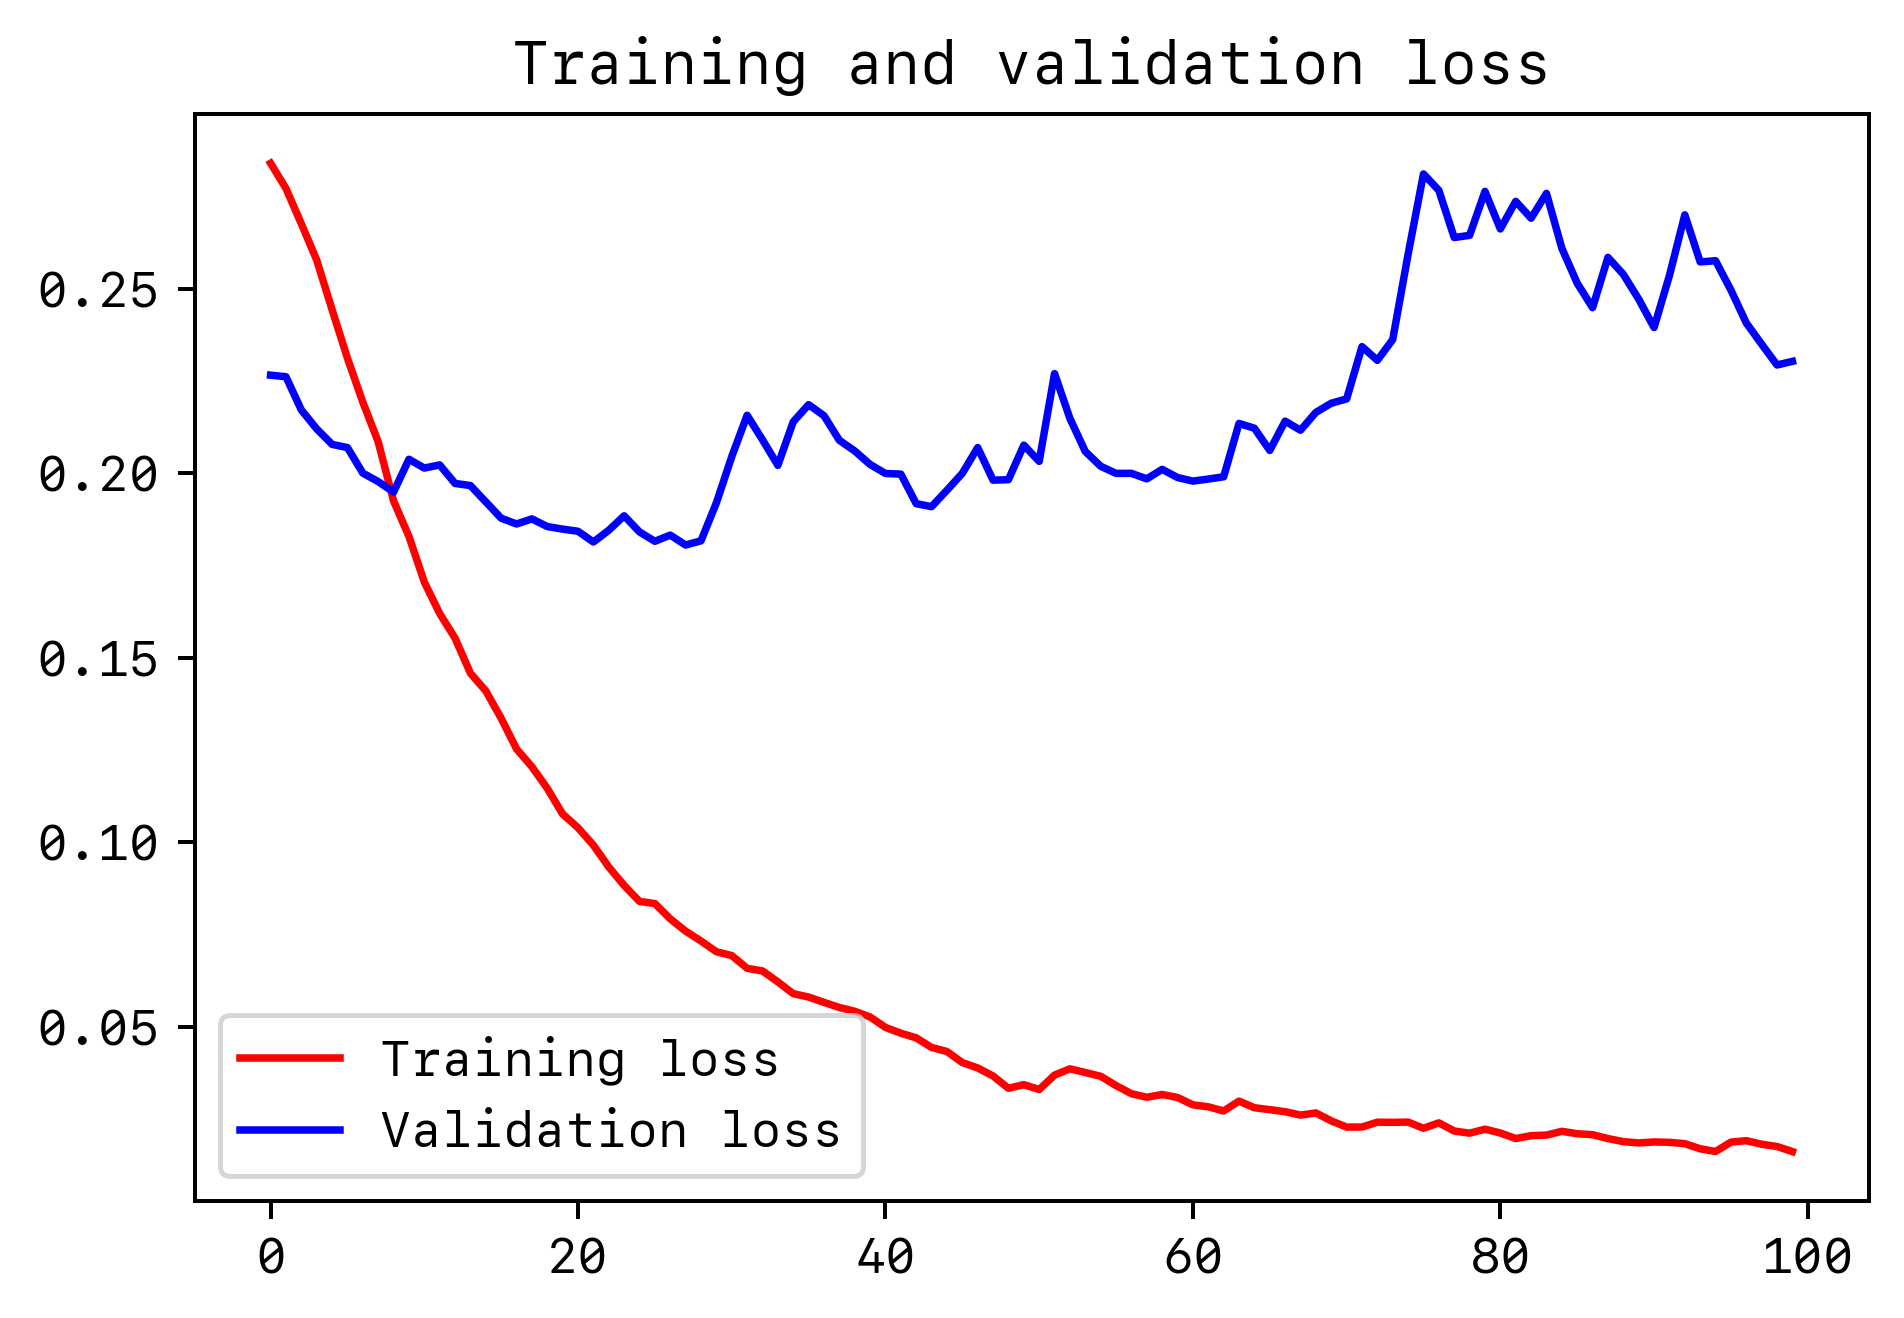

In [35]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


acc = history_enhanced.history['acc']
val_acc = history_enhanced.history['val_acc']
loss = history_enhanced.history['loss']
val_loss = history_enhanced.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, smooth_curve(acc), 'b', color='red', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.plot(epochs, smooth_curve(loss), 'b', color='red', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_loss,test_acc=model_enhanced.evaluate_generator(test_generator,steps=50)
print(test_loss)
print(test_acc)

Found 1000 images belonging to 2 classes.
0.29520227506232916
0.9343999981880188
